/tmp/ipykernel_182266/3893366700.py:14: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./All/all_raw_downsampled.csv')


47
defaultdict(<class 'list'>, {'Normal': [261, 504, 29, 19776, 7910, 25, 18608, 196, 31, 19210, 19522, 100478, 27, 18951, 40, 19022, 37, 19569, 22, 19868, 41232, 19871, 47300, 42182, 46, 31, 25, 28056, 19895, 13194, 9477, 23067, 12443, 0, 395, 163, 8, 3, 20, 0, 361, 0, 31], 'Reconnaissance': [4644], 'Exploits': [9316, 9, 7304]})


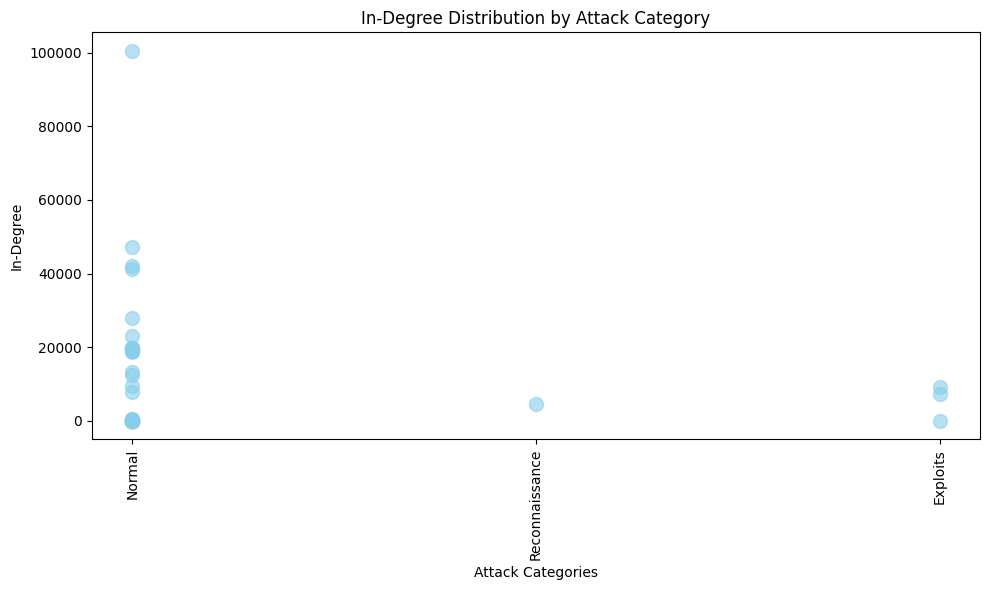

In [12]:
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from UNSW_NB15_config import UNSW_NB15_Config

SOURCE_COL = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_COL = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
LABEL_COL = UNSW_NB15_Config.IS_ATTACK_COL_NAME
CATEGORY_COL = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

df = pd.read_csv('./All/all_raw_downsampled.csv')

G = nx.MultiDiGraph()

# G.add_nodes_from(df[SOURCE_COL].unique())
# G.add_nodes_from(df[DESTINATION_COL].unique())

G.add_edges_from(
    (row[SOURCE_COL], row[DESTINATION_COL], {'attack_category': row[CATEGORY_COL], 'label': row[LABEL_COL]})
    for _, row in df.iterrows()
)

category_in_degrees = defaultdict(list)

for node in G.nodes:
    in_edges = G.in_edges(node, data=True)
    out_edges = G.out_edges(node, data=True)

    attacker = False
    for _, _, data in out_edges:
        if data.get('label') == 1:  # Check if the edge is labeled as an attack
            attacker = True
            category = data.get('attack_category', 'Unknown')
            category_in_degrees[category].append(len(in_edges))
            break

    if not attacker:
        category_in_degrees[BENIGN_CLASS_NAME].append(len(in_edges))

plt.figure(figsize=(10, 6))

print(len(G.nodes))
print(category_in_degrees)

# Prepare data for scatter plot
categories = []
in_degrees = []

for category, degrees in category_in_degrees.items():
    categories.extend([category] * len(degrees))
    in_degrees.extend(degrees)

plt.scatter(categories, in_degrees, color='skyblue', s=100, alpha=0.6)
plt.xlabel('Attack Categories')
plt.ylabel('In-Degree')
plt.title('In-Degree Distribution by Attack Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
def print_attack_node_and_their_in_traffic(df):

    # Strip whitespaces 
    df.columns = df.columns.str.strip()
    
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Find all attacker nodes
    attacker_nodes = df[df[CATEGORY_COL] != BENIGN_CLASS_NAME][SOURCE_COL].unique()
    print("Attacker Nodes:", attacker_nodes)

    # Find all traffic where attacker node is the destination
    directed_to_attacker_traffic = df[df[DESTINATION_COL].isin(attacker_nodes)]

    # Find all nodes that have directed traffic to attacker nodes
    source_node_to_attacker = directed_to_attacker_traffic[SOURCE_COL].unique()
    print("Source Node to Attacker:", source_node_to_attacker)

    attack_directed_to_attacker_traffic = directed_to_attacker_traffic[directed_to_attacker_traffic[CATEGORY_COL] != BENIGN_CLASS_NAME]
    
    print("Example Attacks on Attacker Nodes:", attack_directed_to_attacker_traffic.groupby(SOURCE_COL).head(1))

    print("Source Node to Attacker with Attack Traffic:", attack_directed_to_attacker_traffic[SOURCE_COL].unique())

    print("No of Attacks on Attacker Nodes:", len(attack_directed_to_attacker_traffic))

    directed_to_attacker_traffic_attack_type = directed_to_attacker_traffic[CATEGORY_COL].unique()
    print("Traffic to Attacker Nodes Attack Type:", directed_to_attacker_traffic_attack_type)

print_attack_node_and_their_in_traffic(df)

/tmp/ipykernel_182266/1409605082.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Attacker Nodes: ['175.45.176.0' '175.45.176.3' '175.45.176.2' '175.45.176.1']
Source Node to Attacker: ['149.171.126.18' '149.171.126.11' '149.171.126.15' '149.171.126.17'
 '149.171.126.12' '149.171.126.13' '149.171.126.10' '149.171.126.19'
 '10.40.85.1' '149.171.126.14']
Example Attacks on Attacker Nodes: Empty DataFrame
Columns: [srcip, sport, dstip, dsport, proto, state, dur, sbytes, dbytes, sttl, dttl, sloss, dloss, service, Sload, Dload, Spkts, Dpkts, swin, dwin, stcpb, dtcpb, smeansz, dmeansz, trans_depth, res_bdy_len, Sjit, Djit, Stime, Ltime, Sintpkt, Dintpkt, tcprtt, synack, ackdat, is_sm_ips_ports, ct_state_ttl, ct_flw_http_mthd, is_ftp_login, ct_ftp_cmd, ct_srv_src, ct_srv_dst, ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, attack_cat, label]
Index: []

[0 rows x 49 columns]
Source Node to Attacker with Attack Traffic: []
No of Attacks on Attacker Nodes: 0
Traffic to Attacker Nodes Attack Type: ['Normal']


In [11]:
attack_traffic = df[df[LABEL_COL] == 1]

# Group attack traffic by destination IP and attack category, and count occurrences
attack_traffic_grouped = attack_traffic.groupby([DESTINATION_COL, CATEGORY_COL])

# Print the number of rows in the grouped DataFrame
print(attack_traffic_grouped.size())

dstip           attack_cat    
149.171.126.10  Analysis           315
                Backdoor           312
                Backdoors            1
                DoS               2100
                Exploits          5819
                                  ... 
149.171.126.19  Fuzzers           1934
                Generic            618
                Reconnaissance    1398
                Shellcode          143
                Worms               11
Length: 100, dtype: int64
